In [19]:
import pandas as pd
from src.misc.helper_functions import upload_json_to_cf_s3
import os
from src.db_connector import DbConnector
db_connector = DbConnector()

exec_string = f"""
    SELECT concat('0x', encode(address, 'hex')) as address, contract_name, project_name, sub_category_key, origin_key
    FROM public.blockspace_labels;
"""

df = pd.read_sql(exec_string, db_connector.engine.connect())

Connecting to orbal_writer@orbal-main.cydw1x28knil.us-east-1.rds.amazonaws.com:5432


In [20]:
## put dataframe into a json string
contracts_dict = df.to_dict(orient='records')

In [25]:
upload_json_to_cf_s3(os.getenv("S3_CF_BUCKET"), f'v1/contracts', contracts_dict, os.getenv("CF_DISTRIBUTION_ID"))

... uploaded to v1/contracts


### api.growthepie.xyz

In [1]:

import requests
import pandas as pd

url = 'https://api.growthepie.xyz/v1/fundamentals.json'
response = requests.get(url)
df = pd.DataFrame(response.json())

df.head(8)

## filter df by metric_key == 'txcount' and origin_key == 'base'
df = df[(df['metric_key'] == 'txcount') & (df['origin_key'] == 'base')]


,metric_key,origin_key,date,value
0,daa,imx,2023-04-21,8300.000000
1,txcount,zksync_era,2023-02-14,6.000000
2,daa,imx,2023-04-25,7834.000000
3,txcount,zksync_era,2023-02-15,18.000000
4,fees_paid_usd,imx,2023-04-22,28561.017413
5,txcount,zksync_era,2023-02-16,112.000000
6,fees_paid_usd,imx,2023-04-26,31886.525722
7,txcount,zksync_era,2023-02-17,30.000000


<AxesSubplot:title={'center':'Arbitrum Daily Transactions'}, xlabel='date'>

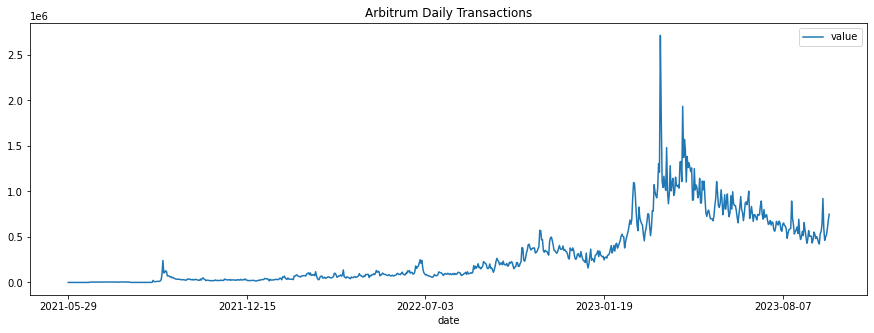

In [11]:
## plot metric txcount over date for all origin_keys and order by date
df[(df['metric_key'] == 'txcount') & (df['origin_key'] == 'arbitrum')].sort_values('date').plot(x='date', y='value', figsize=(15, 5), title='Arbitrum Daily Transactions')



## Airtable labelling help

In [ ]:
### AIRTABLE
import pandas as pd
import airtable
import os

#initialize Airtable instance
AIRTABLE_API_KEY = os.getenv("AIRTABLE_API_KEY")
AIRTABLE_BASE_ID = os.getenv("AIRTABLE_BASE_ID")
at = airtable.Airtable(AIRTABLE_BASE_ID, AIRTABLE_API_KEY)

data = pd.DataFrame([c['fields'] for c in at.get('Unlabeled Contracts')['records']])

In [ ]:
from datetime import datetime,timedelta

from src.db_connector import DbConnector
import src.misc.airtable_functions as at
from eth_utils import to_checksum_address

def read_airtable():
    # read current airtable
    df = at.read_all_airtable()
    if df == False:
        print("Nothing to upload")
    else:
        df['added_on_time'] = datetime.now()
        df.set_index(['address', 'origin_key'], inplace=True)
        # initialize db connection
        db_connector = DbConnector()
        db_connector.upsert_table('blockspace_labels' ,df)


def write_airtable():
    # delete every row in airtable
    at.clear_all_airtable()
    # initialize db connection
    db_connector = DbConnector()
    # get top unlabelled contracts
    df = db_connector.get_unlabelled_contracts('10', '7')
    df['address'] = df['address'].apply(lambda x: to_checksum_address('0x' + bytes(x).hex()))
    # write to airtable
    at.push_to_airtable(df)

read_airtable()
write_airtable()

## web3 test

In [ ]:
from web3 import Web3
import os

tx = '0x9E0B1B1253157E64CD8F44DD15DC193FD9C8B77690A4094EF2CCABB1A389E98D'
url = f"https://rpc.ankr.com/base/{os.getenv('ANKR_API')}"
w3 = Web3(Web3.HTTPProvider(url))

In [ ]:
block = w3.eth.get_block(3913960, full_transactions=True)

In [ ]:
receipt = w3.eth.get_transaction_receipt('0x183513dd1f5194f23263430e9232d38a4f0e6464198f91184da91829e00e4b7a')

In [ ]:
from src.misc.helper_functions import api_post_call
import json
 
payload = {
        "jsonrpc": "2.0",
        "method": "eth_getTransactionReceipt",
        "params": [tx],
        "id": 1
    }
headers = {
    "accept": "application/json",
    "content-type": "application/json"
}

response = api_post_call(url, payload=json.dumps(payload), header=headers)

In [ ]:
block_number_hex = hex(3913960)
payload = {
    "jsonrpc": "2.0",
    "method": "eth_getBlockByNumber",
    "params": [str(block_number_hex), True],
    "id": 1
}
headers = {
    "accept": "application/json",
    "content-type": "application/json"
}

response = api_post_call(url, payload=json.dumps(payload), header=headers)

In [ ]:
from datetime import datetime,timedelta

from src.db_connector import DbConnector
from src.adapters.adapter_raw_rpc import AdapterRPCRaw

adapter_params = {
    'rpc': 'ankr',
    'api_key' : os.getenv("ANKR_API"),
    'chain' : 'base'
}
load_params = {
    'block_start' : 'auto', ## 'auto' or a block number as int
    #'block_start' : 9137631, ## 'auto' or a block number as int
    'batch_size' : 25,
    'threads' : 1
}

# initialize adapter
db_connector = DbConnector()
# initialize adapter
ad = AdapterRPCRaw(adapter_params, db_connector)

## JSON creation

In [ ]:
import os
from src.api.json_creation import JSONCreation
from src.db_connector import DbConnector

db_connector = DbConnector()

json_creator = JSONCreation(os.getenv("S3_CF_BUCKET"), os.getenv("CF_DISTRIBUTION_ID"), db_connector, "v1")
## for testing
#json_creator = JSONCreation(os.getenv("S3_CF_BUCKET"), os.getenv("CF_DISTRIBUTION_ID"), db_connector, "test")

json_creator.create_all_jsons()

# df = json_creator.get_all_data()
# json_creator.create_landingpage_json(df)
# json_creator.create_chain_details_jsons(df)
# json_creator.create_metric_details_jsons(df)
# json_creator.create_fundamentals_json(df)
#json_creator.create_master_json()

In [ ]:
import os
from src.db_connector import DbConnector
from src.api.blockspace_json_creation import BlockspaceJSONCreation
db_connector = DbConnector()
api_version = "v1"

blockspace_json_creator = BlockspaceJSONCreation(os.getenv("S3_CF_BUCKET"), os.getenv("CF_DISTRIBUTION_ID"), db_connector, api_version)
blockspace_json_creator.create_blockspace_overview_json()
blockspace_json_creator.create_blockspace_comparison_json()

## L2Beat

In [1]:
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_l2beat import AdapterL2Beat

adapter_params = {
}
load_params = {
    #'origin_keys' : None,
    'origin_keys' : ['gitcoin_pgn', 'zora'] # see all options in adapter_mapping.py 
}

# initialize adapter
ad = AdapterL2Beat(adapter_params, db_connector)
# extract
df= ad.extract(load_params)
# load
ad.load(df)

Connecting to orbal_writer@orbal-main.cydw1x28knil.us-east-1.rds.amazonaws.com:5432
Adapter L2Beat initialized with {}.
...L2Beat - loaded for zora. Shape: (111, 4)
...L2Beat - loaded for gitcoin_pgn. Shape: (82, 4)
L2Beat extract done for {'origin_keys': ['gitcoin_pgn', 'zora']}. DataFrame shape: (193, 1)
Load L2Beat done - 193 rows upserted in fact_kpis


## DefiLlama

In [ ]:
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_defillama import AdapterDefiLlama

adapter_params = {
}
load_params = {
    'origin_keys' : None,
    #'origin_keys' : ['ethereum'] # see all options in adapter_mapping.py
}

# initialize adapter
ad = AdapterDefiLlama(adapter_params, db_connector)
# extract
df = ad.extract(load_params)
# load
ad.load(df)

## Coingecko

run for projects / chains

In [ ]:
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_coingecko import AdapterCoingecko

adapter_params = {
}
load_params = {
    'load_type' : 'project',
    'metric_keys' : ['price', 'volume', 'market_cap'],
    'origin_keys' : None,
    #'origin_keys' : ['aptos'], # see all options in adapter_mapping.py
    'days' : 'auto', # auto, max, or a number (as string)
    'vs_currencies' : ['usd', 'eth']
}

# initialize adapter
ad = AdapterCoingecko(adapter_params, db_connector)
# extract
df = ad.extract(load_params)
# load
ad.load(df)

and for imx tokens

In [ ]:
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_coingecko import AdapterCoingecko

adapter_params = {
}
load_params = {
    'load_type' : 'imx_tokens'
}

# initialize adapter
ad = AdapterCoingecko(adapter_params, db_connector)
# extract
df = ad.extract(load_params)
# load
ad.load(df)

## Dune

In [1]:
import os
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_dune import AdapterDune

adapter_params = {
    'api_key' : os.getenv("DUNE_API")
}

load_params = {
    'query_names' : ['stables_mcap'], ## fundamentals, waa, stables_mcap, rent_paid
    'days' : 200,
    #'query_names' : None,
    #'days' : 'auto',
}

# initialize adapter
ad = AdapterDune(adapter_params, db_connector)
# extract
df = ad.extract(load_params)
# upload
#ad.load(df)

Connecting to orbal_writer@orbal-main.cydw1x28knil.us-east-1.rds.amazonaws.com:5432


2023-10-03 15:56:52,916 INFO dune_client.base_client executing 2608415 on medium cluster


Adapter Dune initialized with {'api_key': '***'}.
...start loading stables_mcap with query_id: 2608415 and params: [Parameter(name=Days, value=200, type=text)]


2023-10-03 15:56:53,284 INFO dune_client.base_client waiting for query execution 01HBTX7KC6KQ5J7R5BBF43Y55Y to complete: ExecutionState.EXECUTING
2023-10-03 15:56:58,477 INFO dune_client.base_client waiting for query execution 01HBTX7KC6KQ5J7R5BBF43Y55Y to complete: ExecutionState.EXECUTING
2023-10-03 15:57:03,706 INFO dune_client.base_client waiting for query execution 01HBTX7KC6KQ5J7R5BBF43Y55Y to complete: ExecutionState.EXECUTING
2023-10-03 15:57:08,896 INFO dune_client.base_client waiting for query execution 01HBTX7KC6KQ5J7R5BBF43Y55Y to complete: ExecutionState.EXECUTING
2023-10-03 15:57:14,107 INFO dune_client.base_client waiting for query execution 01HBTX7KC6KQ5J7R5BBF43Y55Y to complete: ExecutionState.EXECUTING
2023-10-03 15:57:19,316 INFO dune_client.base_client waiting for query execution 01HBTX7KC6KQ5J7R5BBF43Y55Y to complete: ExecutionState.EXECUTING
2023-10-03 15:57:24,514 INFO dune_client.base_client waiting for query execution 01HBTX7KC6KQ5J7R5BBF43Y55Y to complete: Exe

...finished loading stables_mcap. Loaded 1200 rows
Dune extract done for {'query_names': ['stables_mcap'], 'days': 200}. DataFrame shape: (1200, 1)


In [6]:
ad.load(df)

Load Dune done - 1200 rows upserted in fact_kpis


## Flipside
sometimes some Flipside queries just get stuck -- gotta retrigger them

In [ ]:
import os
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_flipside import AdapterFlipside

adapter_params = {
    'api_key' : os.getenv("FLIPSIDE_API")
}
load_params = {
    'origin_keys' : ['zksync_era'],
    'metric_keys' : ['stables_mcap'],
    'days' : 'auto',
    # 'origin_keys' : None,
    # 'metric_keys' : None,
    # 'days' : 'auto',
}

# initialize adapter
ad = AdapterFlipside(adapter_params, db_connector)
# extract
df = ad.extract(load_params)
# load
ad.load(df)

In [ ]:
## testing the new flipside api

from flipside import Flipside
flipside = Flipside("74c43ebc-3291-4953-8aeb-65640da7c852", "https://api-v2.flipsidecrypto.xyz")

sql = """
 select 
    BLOCK_NUMBER, BLOCK_TIMESTAMP, BLOCK_HASH, TX_HASH, NONCE, POSITION, ORIGIN_FUNCTION_SIGNATURE, FROM_ADDRESS, TO_ADDRESS, ETH_VALUE, TX_FEE, GAS_PRICE, GAS_LIMIT, 
    GAS_USED, L1_GAS_PRICE, L1_GAS_USED, L1_FEE_SCALAR, L1_SUBMISSION_BATCH_INDEX, L1_SUBMISSION_TX_HASH, L1_STATE_ROOT_BATCH_INDEX, 
    L1_STATE_ROOT_TX_HASH, CUMULATIVE_GAS_USED, INPUT_DATA, STATUS
from optimism.core.fact_transactions
where block_number >= 104130000
and block_number < 104135000
order by block_number asc
"""

# Run the query against Flipside's query engine and await the results
query_result_set = flipside.query(sql)

## Zettablock

In [ ]:
import os
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_zettablock import AdapterZettablock

adapter_params = {
    'api_key' : os.getenv("ZETTABLOCK_API")
}
load_params = {
    #'origin_keys' : ['zksync_era', 'polygon_zkevm'],
    #'metric_keys' : ['txcount', ''],
    'days' : 10,
    'origin_keys' : None,
    'metric_keys' : None,
    # 'days' : 'auto',
}

# initialize adapter
ad = AdapterZettablock(adapter_params, db_connector)
# extract
df = ad.extract(load_params)
# load
ad.load(df)

## RPC raw data load

In [ ]:
import os
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_raw_rpc import AdapterRPCRaw

adapter_params = {
    'rpc': 'ankr',
    'api_key' : os.getenv("ANKR_API"),
    'chain' : 'base'
}

load_params = {
    'block_start' : 'auto', ## 'auto' or a block number as int
    #'block_start' : 9137631, ## 'auto' or a block number as int
    'batch_size' : 10,
    'threads' : 5
}

# initialize adapter
ad = AdapterRPCRaw(adapter_params, db_connector)
# extract
ad.extract_raw(load_params)

In [ ]:
import os
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_raw_rpc import AdapterRPCRaw

adapter_params = {
    'rpc': 'ankr',
    'api_key' : os.getenv("ANKR_API"),
    'chain' : 'optimism'
}

load_params = {
    'block_start' : 'auto', ## 'auto' or a block number as int
    #'block_start' : 9137631, ## 'auto' or a block number as int
    'batch_size' : 10,
    'threads' : 5
}

# initialize adapter
ad = AdapterRPCRaw(adapter_params, db_connector)
# extract
ad.extract_raw(load_params)

## Adapter Nader

In [ ]:
import os
from src.adapters.adapter_nader import BaseNodeAdapter
from src.db_connector import DbConnector
adapter_params = {
    'rpc': 'local_node',
    'chain': 'base',
    'node_url': os.getenv("BASE_NODE"),
}

# Initialize DbConnector
db_connector = DbConnector()

# Initialize BaseNodeAdapter
adapter = BaseNodeAdapter(adapter_params, db_connector)

# Test database connectivity
if not adapter.check_db_connection():
    print("Failed to connect to database.")
else:
    print("Successfully connected to database.")

# Test S3 connectivity
if not adapter.check_s3_connection():
    print("Failed to connect to S3.")
else:
    print("Successfully connected to S3.")

# Test run method
load_params = {
    'block_start': 'auto',
    'batch_size': 10,
    'threads': 5,
}

adapter.extract_raw(load_params)

## ZettaBlock raw data load

In [ ]:
import os
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_raw_zettablock import AdapterZettaBlockRaw

adapter_params = {
    'api_key' : os.getenv("ZETTABLOCK_API")
}

load_params = {
    #'keys' : ['polygon_zkevm_tx', 'zksync_era_tx'],
    'keys' : ['zksync_era_tx'],
    #'block_start' : 'auto', ## 'auto' or a block number as int
    'block_start' : 9137631, ## 'auto' or a block number as int
}

# initialize adapter
ad = AdapterZettaBlockRaw(adapter_params, db_connector)
# extract
ad.extract_raw(load_params, if_exists = 'ignore')

## Chainbase raw

In [ ]:
import os
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_raw_chainbase import AdapterChainbaseRaw

adapter_params = {
    'api_key' : os.getenv("CHAINBASE_API")
}

load_params = {
    'keys' : ['arbitrum_tx'],
    #'block_start' : 'auto', ## 'auto' or a block number as int
    'block_start' : 64900000, ## until 65,570,000
}

# initialize adapter
ad = AdapterChainbaseRaw(adapter_params, db_connector)
# extract
ad.extract_raw(load_params)

## IMX raw data load

In [ ]:
## implement orchestration?

from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_raw_imx import AdapterRawImx

adapter_params = {
    'load_types' : ['withdrawals', 'deposits', 'trades', 'orders_filled', 'transfers', 'mints'],
    'forced_refresh' : 'no',

    #'load_types' : ['orders_filled'],
    #'forced_refresh' : '2023-04-01T00:00:00.000000Z',
}

# initialize adapter
ad = AdapterRawImx(adapter_params, db_connector)
# extract raw (and load raw in case of IMX)
df_raw = ad.extract_raw()

## Flipside raw data load

In [ ]:
import os
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_raw_flipside import AdapterFlipsideRaw

adapter_params = {
    'api_key' : os.getenv("FLIPSIDE_API")
}

load_params = {
    'keys' : ['arbitrum_tx', 'optimism_tx'],
    'block_start' : 'auto',
}

# initialize adapter
ad = AdapterFlipsideRaw(adapter_params, db_connector)
# extract
df = ad.extract_raw(load_params)

## SQL aggregation

In [7]:
## Loads currently IMX txcount, daa, fees_paid
## also loads user_base_weekly

from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_sql import AdapterSQL

adapter_params = {
}

load_params = {
    'load_type' : 'metrics', ## usd_to_eth or metrics or blockspace
    
    #'days' : 'auto', ## days as int our 'auto
    'origin_keys' : None, ## origin_keys as list or None
    #'metric_keys' : None, ## metric_keys as list or None

    'days' : '1400', ## days as int our 'auto
    #'origin_keys' : ['zora', 'gitcoin_pgn'], ## origin_keys as list or None
    'metric_keys' : ['profit_usd'], ## metric_keys as list or None
}

# initialize adapter
ad = AdapterSQL(adapter_params, db_connector)

# extract
df = ad.extract(load_params)
# # load
ad.load(df)

Connecting to orbal_writer@orbal-main.cydw1x28knil.us-east-1.rds.amazonaws.com:5432
Adapter SQL Aggregation initialized with {}.
... executing query: profit_usd - multi with {'Days': '1400'} days
...query loaded: profit_usd multi with 1400 days. DF shape: (2410, 4)
SQL Aggregation extract done for {'load_type': 'metrics', 'origin_keys': None, 'days': '1400', 'metric_keys': ['profit_usd']}. DataFrame shape: (2410, 1)


In [7]:
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_sql import AdapterSQL

adapter_params = {
}

load_params = {
    'load_type' : 'usd_to_eth', ## usd_to_eth or metrics or blockspace
    'days' : 200, ## days as int
    'origin_keys' : None, ## origin_keys as list or None
    'metric_keys' : None, ## metric_keys as list or None
}

# initialize adapter
ad = AdapterSQL(adapter_params, db_connector)

# extract
df = ad.extract(load_params)
# # load
ad.load(df)

Connecting to orbal_writer@orbal-main.cydw1x28knil.us-east-1.rds.amazonaws.com:5432
Adapter SQL Aggregation initialized with {}.
load usd values for : 'tvl', 'rent_paid_usd', 'profit_usd', 'fees_paid_usd', 'stables_mcap', 'txcosts_median_usd'
SQL Aggregation extract done for {'load_type': 'usd_to_eth', 'days': 200, 'origin_keys': None, 'metric_keys': None}. DataFrame shape: (8328, 1)
Load SQL Aggregation done - 8328 rows upserted in fact_kpis


In [1]:
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_sql import AdapterSQL

adapter_params = {
}

load_params = {
    'load_type' : 'profit', ## usd_to_eth or metrics or blockspace or profit
    'days' : 200, ## days as int
    'origin_keys' : None, ## origin_keys as list or None
    'metric_keys' : None, ## metric_keys as list or None
}

# initialize adapter
ad = AdapterSQL(adapter_params, db_connector)

# extract
df = ad.extract(load_params)
# # load
ad.load(df)

Connecting to orbal_writer@orbal-main.cydw1x28knil.us-east-1.rds.amazonaws.com:5432
Adapter SQL Aggregation initialized with {}.
... executing query: profit_usd - multi with {'Days': 200} days
...query loaded: profit_usd multi with 200 days. DF shape: (1239, 4)
SQL Aggregation extract done for {'load_type': 'profit', 'days': 200, 'origin_keys': None, 'metric_keys': None}. DataFrame shape: (1239, 1)


In [3]:
ad.load(df)

Load SQL Aggregation done - 1239 rows upserted in fact_kpis


In [ ]:
from src.db_connector import DbConnector
db_connector = DbConnector()
from src.adapters.adapter_sql import AdapterSQL

adapter_params = {
}

load_params = {
    'load_type' : 'blockspace', ## usd_to_eth or metrics or blockspace
    'days' : '300', ## days as or auto
    #'origin_keys' : ['arbitrum', 'zksync_era', 'polygon_zkevm', 'optimism', 'base', 'imx'], ## origin_keys as list or None
    'origin_keys' : ['base']
}

# initialize adapter
ad = AdapterSQL(adapter_params, db_connector)

# extract
ad.extract(load_params)

### Blockspace logic
- for each chain, aggregate the daily contracts usage


In [ ]:
from src.db_connector import DbConnector
from src.misc.helper_functions import get_missing_days_blockspace
db_connector = DbConnector()

chain_list = ['optimism']
#chain_list = ['arbitrum', 'zksync_era', 'polygon_zkevm', 'optimism']

In [ ]:
for chain in chain_list:
    #days = get_missing_days_blockspace(db_connector, chain)
    days = 10000

    # ## aggregate contract data
    # print(f"aggregating contract data for {chain} and last {days} days...")
    # df = db_connector.get_blockspace_contracts(chain, days)
    # df.set_index(['address', 'date', 'origin_key'], inplace=True)

    # print(f"upserting contract data for {chain}. Total rows: {df.shape[0]}...")
    # db_connector.upsert_table('blockspace_fact_contract_level', df)

    # ## determine total usage
    # print(f"aggregating total usage for {chain} and last {days} days...")
    # df = db_connector.get_blockspace_total(chain, days)
    # df.set_index(['date', 'sub_category_key' ,'origin_key'], inplace=True)

    # print(f"upserting total usage usage for {chain}. Total rows: {df.shape[0]}...")
    # db_connector.upsert_table('blockspace_fact_sub_category_level', df)

    # ## aggregate native transfers
    # print(f"aggregating native_transfers for {chain} and last {days} days...")
    # df = db_connector.get_blockspace_native_transfers(chain, days)
    # df.set_index(['date', 'sub_category_key' ,'origin_key'], inplace=True)

    # print(f"upserting native_transfers for {chain}. Total rows: {df.shape[0]}...")
    # db_connector.upsert_table('blockspace_fact_sub_category_level', df)

    # ## aggregate contract deployments
    # print(f"aggregating smart_contract_deployments for {chain} and last {days} days...")
    # df = db_connector.get_blockspace_contract_deplyments(chain, days)
    # df.set_index(['date', 'sub_category_key' ,'origin_key'], inplace=True)

    # print(f"upserting smart_contract_deployments for {chain}. Total rows: {df.shape[0]}...")
    # db_connector.upsert_table('blockspace_fact_sub_category_level', df)

    # ALL below needs to be retriggerd when mapping changes (e.g. new addresses got labeled or new categories added etc.)
    ## aggregate by sub categories
    print(f"aggregating sub categories for {chain} and last {days} days...")
    df = db_connector.get_blockspace_sub_categories(chain, days)
    df.set_index(['date', 'sub_category_key' ,'origin_key'], inplace=True)

    print(f"upserting sub categories for {chain}. Total rows: {df.shape[0]}...")
    db_connector.upsert_table('blockspace_fact_sub_category_level', df)

    ## determine unlabeled usage
    print(f"aggregating unlabeled usage for {chain} and last {days} days...")
    df = db_connector.get_blockspace_unlabeled(chain, days)
    df.set_index(['date', 'sub_category_key' ,'origin_key'], inplace=True)

    print(f"upserting unlabeled usage for {chain}. Total rows: {df.shape[0]}...")
    db_connector.upsert_table('blockspace_fact_sub_category_level', df)


# days = get_missing_days_blockspace(db_connector, 'imx')

# df = db_connector.get_blockspace_imx(days)
# df.set_index(['date', 'sub_category_key' ,'origin_key'], inplace=True)

# print(f"...upserting imx data . Total rows: {df.shape[0]}...")
# db_connector.upsert_table('blockspace_fact_sub_category_level', df)

In [ ]:
from src.db_connector import DbConnector
db_connector = DbConnector()

In [ ]:
df = db_connector.get_top_contracts_by_category('main_category', 'unlabeled', 'arbitrum', 'gas', 7)

In [ ]:
print(df.to_markdown())

## S3

In [ ]:
## connect to s3 bucket and output list of files
import pandas as pd
import boto3
import os

s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY")
)

bucket = s3.Bucket('gtp-longterm')

## get list of files in bucket with last modified date
files = []
for obj in bucket.objects.all():
    files.append([obj.key, obj.last_modified])

df = pd.DataFrame(files, columns=['key', 'last_modified'])

## filter out files where key starts with 'imx'
df = df[~df.key.str.startswith('imx')]

df['chain'] = df.key.str.split('/').str[0]

## create new column block_range that extracts the string between 'tx_' and '.parquet' in the key column using lambda function
df['block_range'] = df.key.apply(lambda x: x[x.find('tx_')+3:x.find('.parquet')])
df['block_start'] = df.block_range.str.split('-').str[0].astype(int)
df['block_end'] = df.block_range.str.split('-').str[1].astype(int)

## sort by block_start
df.sort_values(by='block_start', inplace=True, ascending=True)

In [ ]:
df

### Arbitrum

In [ ]:
df_arbitrum = df[df.chain == 'arbitrum']

In [ ]:
df_arbitrum

In [ ]:
## load first file in df_arbitrum into df
df_arbitrum_flipside = pd.read_parquet(f"s3://gtp-longterm/{df_arbitrum.key.iloc[0]}")
df_arbitrum_flipside.sort_values(by='ETH_VALUE', inplace=True, ascending=False)
df_arbitrum_flipside.head(10)

In [ ]:
## load first file in df_arbitrum with block_start >= 96528665 into df
df_arbitrum_chainbase = pd.read_parquet(f"s3://gtp-longterm/{df_arbitrum[df_arbitrum.block_start >= 96528665].key.iloc[10]}")
df_arbitrum_chainbase.head()

### Optimism

In [ ]:
df_optimism = df[df.chain == 'optimism']

In [ ]:
## load first file in df_arbitrum into df
df_optimism_flipside = pd.read_parquet(f"s3://gtp-longterm/{df_optimism.key.iloc[0]}")
df_optimism_flipside.head()

In [ ]:
# df_optimism_flipside[['TX_HASH', 'ETH_VALUE', 'TX_FEE', 'GAS_PRICE', 'GAS_LIMIT', 'GAS_USED',
#        'L1_GAS_PRICE', 'L1_GAS_USED', 'L1_FEE_SCALAR',  'CUMULATIVE_GAS_USED' ]]

## filter df_optimism_flipside where TX_HASH = 0xA5E0DACD8D29020C04139F8506C01CBA8B6E561CE567DF8DA35857722232F559 and select columns 'TX_HASH', 'ETH_VALUE', 'TX_FEE', 'GAS_PRICE', 'GAS_LIMIT', 'GAS_USED','L1_GAS_PRICE', 'L1_GAS_USED', 'L1_FEE_SCALAR',  'CUMULATIVE_GAS_USED' 

df_optimism_flipside[df_optimism_flipside.TX_HASH == '0xA5E0DACD8D29020C04139F8506C01CBA8B6E561CE567DF8DA35857722232F559'.lower()][['TX_HASH', 'ETH_VALUE', 'TX_FEE', 'GAS_PRICE', 'GAS_LIMIT', 'GAS_USED','L1_GAS_PRICE', 'L1_GAS_USED', 'L1_FEE_SCALAR',  'CUMULATIVE_GAS_USED' ]]

In [ ]:
df_optimism_flipside['GAS_PRICE'] / 1e9

In [ ]:
df_optimism_flipside.columns

In [ ]:
## load first file in df_arbitrum with block_start >= 96528665 into df
df_optimism_chainbase = pd.read_parquet(f"s3://gtp-longterm/{df_optimism[df_optimism.block_start >= 103428989].key.iloc[0]}")
df_optimism_chainbase.head()

### Polygon zkEVM

In [ ]:
df_polygon = df[df.chain == 'polygon_zkevm']

In [ ]:
## load first file in df_arbitrum into df
df_polygon_zb = pd.read_parquet(f"s3://gtp-longterm/{df_polygon.key.iloc[0]}")
df_polygon_zb.head()

### zkSync Era

In [ ]:
df_zksync = df[df.chain == 'zksync_era']

In [ ]:
## load first file in df_arbitrum into df
df_zksync_zb = pd.read_parquet(f"s3://gtp-longterm/{df_zksync.key.iloc[0]}")
df_zksync_zb.head()

In [ ]:
# ## rename files in S3 bucket that contain 'block_'
# for index, row in df[df.key.str.contains('block_')].iterrows():
#     print(row['key'])
#     old_key = row['key']
#     new_key = old_key.replace('block_', '')
#     print(new_key)
#     s3.Object('gtp-longterm', new_key).copy_from(CopySource='gtp-longterm/'+old_key)
#     #s3.Object('gtp-longterm', old_key).delete()


In [ ]:
df_arbitrum[df_arbitrum.block_start >= 96528665].sort_values(by='last_modified', ascending=True)

In [ ]:
main_zksync()

## indexed.xyz

In [ ]:
import boto3

aws_access_key_id = "43c31ff797ec2387177cabab6d18f15a"
aws_secret_access_key = "afb354f05026f2512557922974e9dd2fdb21e5c2f5cbf929b35f0645fb284cf7"
bucket_name = 'indexed-xyz'

s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
        )

In [ ]:
## list all files in bucket
for obj in s3.list_objects(Bucket=bucket_name)['Contents']:
    print(obj['Key'])